In [93]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle

## Обработка данных

Считаем датасет и выведем основные статистики 

In [94]:
data = pd.read_csv('data/df_hw.csv', index_col=0)

In [95]:
data['day'].unique()

array([ 8,  5, 15,  1,  7,  9,  2, 11,  4, 16, 13,  0, 14,  3, 18, 12,  6,
       10, 19, 17], dtype=int64)

In [96]:
data.head()

,user_id,metric,day
4768,4768,5210.050500,8
1928,1928,1617.534800,8
2995,2995,6742.954000,5
15885,5885,8998.112105,15
6121,6121,2281.206200,1


In [97]:
data.describe()

,user_id,metric,day
count,20000.000000,20000.000000,20000.000000
mean,4999.500000,5608.495781,9.500000
std,2886.823503,2694.961977,5.766425
min,0.000000,1000.208700,0.000000
25%,2499.750000,3529.527850,4.750000
50%,4999.500000,5325.799848,9.500000
75%,7499.250000,7531.320458,14.250000
max,9999.000000,15645.966244,19.000000


Разобьем данные на 2 группы (первые десять дней, вторые десять дней)

In [98]:
data_aa_1 = data[data['day'] <= 9]

In [99]:
data_aa_2 = data[data['day'] > 9]

Посмотрим на распределение данных

(array([426., 490., 531., 556., 533., 579., 562., 595., 617., 624., 644.,
        662., 634., 628., 361., 212., 179., 139., 112., 102., 114.,  82.,
         78.,  78.,  65.,  67.,  67.,  59.,  70.,  40.,  47.,  47.]),
 array([1000.2087    , 1281.05661563, 1561.90453125, 1842.75244688,
        2123.6003625 , 2404.44827813, 2685.29619375, 2966.14410938,
        3246.992025  , 3527.83994063, 3808.68785625, 4089.53577188,
        4370.3836875 , 4651.23160313, 4932.07951875, 5212.92743438,
        5493.77535   , 5774.62326563, 6055.47118125, 6336.31909688,
        6617.1670125 , 6898.01492813, 7178.86284375, 7459.71075938,
        7740.558675  , 8021.40659063, 8302.25450625, 8583.10242188,
        8863.9503375 , 9144.79825312, 9425.64616875, 9706.49408438,
        9987.342     ]),
 <BarContainer object of 32 artists>)

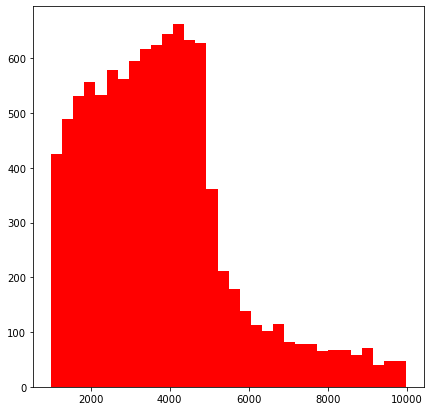

In [100]:
plt.figure(figsize=(7,7))
plt.hist(data_aa_1['metric'], bins = 32, color='red',  linewidth=2)

(array([  1.,  22.,  24.,  60., 131., 220., 403., 537., 644., 725., 798.,
        873., 850., 917., 784., 681., 527., 417., 305., 251., 165., 118.,
        113., 109.,  82.,  86.,  66.,  46.,  23.,  14.,   3.,   5.]),
 array([ 1812.18974488,  2244.49526049,  2676.8007761 ,  3109.10629171,
         3541.41180732,  3973.71732293,  4406.02283854,  4838.32835415,
         5270.63386976,  5702.93938537,  6135.24490098,  6567.55041659,
         6999.8559322 ,  7432.16144781,  7864.46696343,  8296.77247904,
         8729.07799465,  9161.38351026,  9593.68902587, 10025.99454148,
        10458.30005709, 10890.6055727 , 11322.91108831, 11755.21660392,
        12187.52211953, 12619.82763514, 13052.13315075, 13484.43866636,
        13916.74418197, 14349.04969759, 14781.3552132 , 15213.66072881,
        15645.96624442]),
 <BarContainer object of 32 artists>)

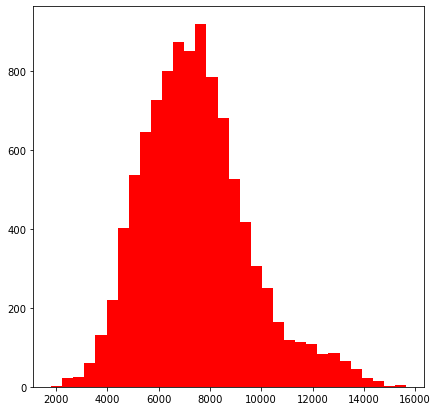

In [101]:
plt.figure(figsize=(7,7))
plt.hist(data_aa_2['metric'], bins = 32, color='red',  linewidth=2)

## A/A Тест

Проведем А/A на исторических данных и убедимся в корректности дизайна эксперимента

In [102]:
p_values = []
iters = 10000
alpha = 0.05
eff_size = 0.02
for _ in range(iters):
    group_A = data_aa_1['metric'].sample(n = 4000).values
    group_B = data_aa_1['metric'].sample(n = 4000).values
    p = scipy.stats.ttest_ind(group_A, group_B, equal_var=False).pvalue
    p_values.append(p)
p_values = np.array(p_values)
print(p_values[p_values < alpha].shape[0] / p_values.shape[0])

0.0117


(array([ 356.,  607.,  791.,  968., 1083., 1190., 1140., 1264., 1283.,
        1318.]),
 array([0.00190549, 0.10169714, 0.2014888 , 0.30128045, 0.4010721 ,
        0.50086376, 0.60065541, 0.70044706, 0.80023872, 0.90003037,
        0.99982202]),
 <BarContainer object of 10 artists>)

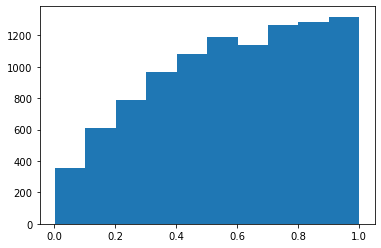

In [103]:
plt.hist(p_values)

## A/B Тест

Добавим эффект в 2% за максимально возможное число дней и подберем такую подвыборку, что получим мощность более 80%

In [104]:
p_values = []
iters = 10000
alpha = 0.05
eff_size = 0.02
for _ in range(iters):
    group_A = data_aa_2['metric'].sample(n = 4000).values
    group_B = data_aa_2['metric'].sample(n = 4000).values * (1. + eff_size)
    p = scipy.stats.ttest_ind(group_A, group_B, equal_var=False).pvalue
    p_values.append(p)
p_values = np.array(p_values)
print(p_values[p_values < alpha].shape[0] / p_values.shape[0])

0.9381


Отсюда убеждаемся, что мы можем зафиксировать эффект в 2% с вероятностью 80% для максимально возможного числа дней.

(array([9.653e+03, 2.250e+02, 7.100e+01, 2.600e+01, 1.100e+01, 8.000e+00,
        5.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([2.61095123e-10, 7.91152903e-02, 1.58230580e-01, 2.37345870e-01,
        3.16461160e-01, 3.95576450e-01, 4.74691740e-01, 5.53807030e-01,
        6.32922320e-01, 7.12037610e-01, 7.91152900e-01]),
 <BarContainer object of 10 artists>)

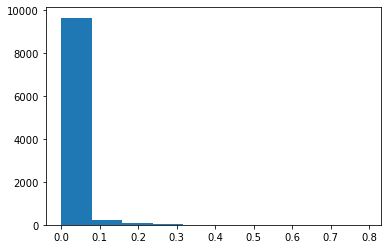

In [105]:
plt.hist(p_values)

Далее найдем минимальное количество дней, при котором вылавливается эффект в 2% с вероятностью 80%

In [106]:
def criteria(group_A, group_B, criteria_value='ttest_ind'):
    if criteria_value == 'mannwhitneyu':
        return scipy.stats.mannwhitneyu(group_A, group_B, alternative='two-sided').pvalue
    else:
        return scipy.stats.ttest_ind(group_A, group_B, equal_var=False).pvalue
        

Функция power_by_n_days возвращает power(мощность) и массив p_value для эксперимента длительностью в n_days дней для групп размером group_size из выборки df, с количеством итераций iters, с эффектом eff_size, с уровнем значимости alpha, c критерием criteria_value

In [107]:
def power_by_n_days(df, n_days, eff_size=0.02, iters=10000, alpha=0.05, group_size = None, criteria_value='ttest_ind'):
    max_days = int(max(df['day'].unique())) + 1
    data_start = int(min(df['day'].unique()))
    data_end = data_start + n_days - 1
    days_iters = max_days - data_start - n_days + 1
    p_values = []
    power = []
    for i in range(days_iters):
        data_current = df[((df['day'] >= (data_start + i)) & (df['day'] <= (data_end + i)))]
        if((group_size is None) or (group_size > len(data_current))):
            group_size = len(data_current)
        p_values_current = []
        for _ in range(iters):
            group_A = data_current['metric'].sample(n = group_size).values
            group_B = data_current['metric'].sample(n = group_size).values * (1. + eff_size)
            p = criteria(group_A, group_B, criteria_value)
            p_values_current.append(p)
        p_values_current = np.array(p_values_current)
        p_values.append(p_values_current)
        power.append(p_values_current[p_values_current < alpha].shape[0] / p_values_current.shape[0])
    return p_values, power

Мы запустили функцию для количества дней от 3 до 20 (ресурсоемко). Ниже приведен фрагмент кода для быстрого поиска минимального количества дней.

Найдем нужное количество дней. Для этого найдем минимальное количество дней, для которого все мощности больше 0.8:

In [108]:
min_n_days = 1
for j in range(1, 10):
    p_values_results_current, power_results_current = power_by_n_days(data_aa_2, j)
    power_results_current = np.array(power_results_current)
    # Проверим, что нет ни одного промежутока,который бы не удовлетворял условию того, что мощность менее 80%
    if (len(power_results_current[power_results_current < 0.8]) == 0):
        min_n_days = j
        break
print(min_n_days)
for j in range(1, 10):
    p_values_results_current, power_results_current = power_by_n_days(data_aa_1, j)
    power_results_current = np.array(power_results_current)
    # Проверим, что нет ни одного промежутока,который бы не удовлетворял условию того, что мощность менее 80%
    if (len(power_results_current[power_results_current < 0.8]) == 0):
        min_n_days = j
        break
print(f"Минимальное количество дней: {min_n_days}")

2
Минимальное количество дней: 5


## Возможные улучшения для детектирования эффекта в 2% для 3-ех дней

Мощность критерия зависит от следующих факторов:
1. размер выборки;
2. размер отклонения от нулевой гипотезы;
3. чувствительность статистики критерия;
4. тип альтернативы.

Для увеличения мощности необходимо увеличить размер выборки (текущей не хватает). При уменьшении размера выборки мощность уменьшается для эффекта в 2%.

Пункты 2-4 по факту зависят от выбранного критерия

Проверим детектируется ли эффект в 2% для критерия Стьюдента и Манна-Уитни в течении 3-ех дней

In [113]:
p_values_3, power_3 = power_by_n_days(data_aa_2, 3)
power_3 = np.array(power_3)

In [114]:
# Проверим есть ли хотя бы один промежуток,который удовлетворяет условию того, что мощность менее 80%
if(len(power_3[power_3 < 0.8]) != 0):
    print("Есть промежуток, мощность которого менее 80% => при таких условиях не можем задетекить эффект в 2%")

Для критерия Стьюдента (как видим из данных выше) 3-ех дней не хватает для детектирования 2% эффекта (возможно, необходимо просмотреть другие, более мощные критерии)

In [115]:
p_values_3, power_3 = power_by_n_days(data_aa_2, 3, criteria_value='mannwhitneyu')
power_3 = np.array(power_3)

In [116]:
# Проверим есть ли хотя бы один промежуток,который удовлетворяет условию того, что мощность менее 80%
if(len(power_3[power_3 < 0.8]) != 0):
    print("Есть промежуток, мощность которого менее 80% => при таких условиях не можем задетекить эффект в 2%")

Для критерия Манна-Уитни (как видим из данных выше) 3-ех дней не хватает для детектирования 2% эффекта (возможно, необходимо просмотреть другие, более мощные критерии)